# Performing NER and Sentimental Analysis on Education related articles of The Hindu

In [1]:
# Import necessary packages
import nltk
from nltk.tokenize import word_tokenize, regexp_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.text import TextCollection
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

import spacy
from spacy import displacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")

from matplotlib import pyplot as plt
import seaborn as sb
%matplotlib inline
import pandas as pd
import numpy as np

from pprint import pprint
from pymongo import MongoClient

## Fetching the articles belonging to relevant collection

In [2]:
# fetch the article collection
client = MongoClient()
db = client["TheHindu"]
col = db['education']
article = []
for item in col.find():
    article.append(item['content'])
print('Number of articles found:', len(article))

Number of articles found: 46


In [3]:
# Basic exploration
corpus = ' '.join(article)
stoplist = stopwords.words('english')
tokens = [token for token in regexp_tokenize(corpus, '\w+') if len(token) > 1 and not token.isdigit() and token.lower() not in stoplist]
freqdist = nltk.FreqDist(tokens)
print('Total number of tokens found:', len(freqdist))

Total number of tokens found: 5103


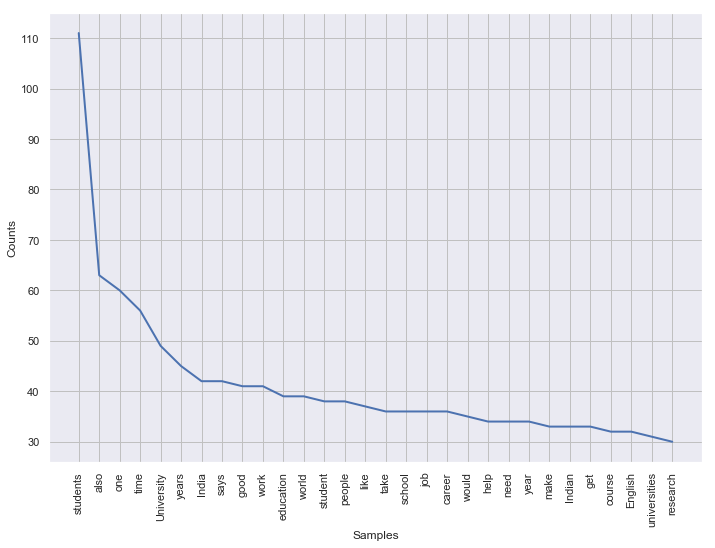

In [4]:
sb.set(rc={'figure.figsize':(11.7,8.27)})
freqdist.plot(30)

## Demonstrating NER on a single article using Spacy

In [5]:
# perform ner on each article
print(article[0])

College is about setting up your future by securing good grades and participating in extracurricular activities that help shape and polish your personality. The experience also requires you to manage a decent lifestyle within minimum means and supplies. Here’s how you can make the best out of the available resources and limited pocket money. For studying As the saying goes, work smart not hard. Use these hacks to complete your syllabus with less stress and fatigue, to arrange for study materials at affordable prices, and to prepare for exams effortlessly. For extra activities College requires socialising, which requires money to be spent to hangout after classes. These hacks ensure you don’t stay indoors due to being broke. For hostel/dorms Worry not if your dorm doesn’t have the utensils or appliances to live a home-like life.


In [6]:
displacy.render(nlp(article[0]), jupyter=True, style='ent')

## Perfroming NER to find Named Entities in a corpus. Results are narrowed down to Persons, Organizations and GeoPolitical Entities only.

In [7]:
def getNE(text):
    ne = {}
    for x in nlp(text).ents:
        entity, label = x.text.strip(), x.label_
        if(label in ['GPE', 'PERSON', 'ORG'] and len(entity) > 1 and entity.lower() not in stoplist):
            ne[entity] = label
    return ne

In [8]:
getNE(corpus)

{'Worry': 'PERSON',
 'Kolukkumalai': 'PERSON',
 'Daksha': 'GPE',
 'MIT': 'ORG',
 'S. Thamarai Selvi': 'PERSON',
 'Centre for Technology Development & Transfer': 'ORG',
 'Anna University': 'ORG',
 'Chennai': 'PERSON',
 'Dhaksha': 'PERSON',
 'Thiruvannamalai': 'PERSON',
 'Team Dhaksha': 'PERSON',
 'APJ Abdul Kalam': 'PERSON',
 'Centre for Aerospace Research': 'ORG',
 'Madras Institute of Technology': 'ORG',
 'Tamil Nadu': 'ORG',
 'Aviation Electronics': 'ORG',
 'Kalam': 'PERSON',
 'the Department of Science & Technology': 'ORG',
 'K Senthilkumar': 'PERSON',
 'DRDO': 'ORG',
 'GATE': 'ORG',
 'non-GATE': 'ORG',
 'UAV': 'ORG',
 'TN Innovation Initiative Scheme': 'ORG',
 'Thamarai Selvi': 'PERSON',
 'DARPA': 'ORG',
 'Savannah': 'GPE',
 'Georgia': 'GPE',
 'India': 'GPE',
 'U.S.': 'GPE',
 'Mohammad Rasheed': 'PERSON',
 'Federation Aeronautique Internationale': 'ORG',
 'FAI': 'ORG',
 'HADR': 'ORG',
 'Dalby Model Aero Club': 'ORG',
 'Queensland': 'GPE',
 'Australia': 'GPE',
 'APJ': 'ORG',
 'Abdul

## Performing sentimental analysis for each entity detected in all the articles. The method also involves checking upto 3 sentences ahead if the entity is found in a sentence, to include the further sentences with pronouns for the same entity.

In [9]:
# loop through the sentences containing each NER can calculate the sentiment score and average it.
def getSentimentScore(term, corpus):
    sia = SentimentIntensityAnalyzer()
    scores = []
    sentences = sent_tokenize(corpus)
    weights = [1, 0.75, 0.5, 0.25]
    for i in range(len(sentences)):
        sentence = sentences[i]
        if term in sentence:
            scores.append(sia.polarity_scores(sentence)['compound'])
            x = i+1
            while(x < len(sentences) and x-i <= 3):
                if term in sentences[x]:
                    break
                for word, tag in pos_tag(word_tokenize(sentences[x])):
                    if tag in ['PRP', 'PRP$']:
                        scores.append(sia.polarity_scores(sentences[x])['compound'] * weights[x-i])
                        break
                x += 1

    avg_sent_score = round(sum(scores)/len(scores), 5) if len(scores)>0 else 0
    return avg_sent_score

In [10]:
# organising the enities and their scores in a dictionary on the base of entity types
nes = getNE(corpus)
sent_scores = {}
for ne in nes:
    ne_tag = nes[ne]
    if ne_tag not in sent_scores:
        sent_scores[ne_tag] = []
    sent_scores[ne_tag].append((ne, getSentimentScore(ne, corpus)))

In [11]:
# Sorting the entities in increasing order of sentiment score.
for ne_tag in sent_scores:
    sent_scores[ne_tag] = sorted(sent_scores[ne_tag], key=lambda x: x[1])

In [12]:
pprint(sent_scores)

{'GPE': [('Ganga', -0.5574),
         ('Yamuna', -0.5574),
         ('Tibet', -0.16192),
         ('Wexford', -0.15416),
         ('Amsterdam', -0.14317),
         ('Daksha', -0.12163),
         ('Golden Jubilee', -0.07723),
         ('M.A.', -0.07723),
         ('Germany', -0.05122),
         ('Coal India', -0.01418),
         ('Paris', -0.00177),
         ('McGill', 0.0),
         ('Toronto', 0.0),
         ('British Columbia', 0.0),
         ('UK', 0.0),
         ('Astronomy', 0.0),
         ('non-Commonwealth', 0.0),
         ('Pitampura', 0.0),
         ('a _', 0.00299),
         ('London', 0.00634),
         ('New Jersey', 0.01059),
         ('Italy', 0.01059),
         ('Poland', 0.01059),
         ('Delhi', 0.01619),
         ('Bengaluru', 0.02572),
         ('Graduate', 0.03464),
         ('Bombay', 0.04546),
         ('New Delhi', 0.04977),
         ('Ehsaas', 0.05096),
         ('Collegify', 0.06123),
         ('Hyderabad', 0.06728),
         ('Uber', 0.07216),
         ('CA

In [13]:
print('Total NE detected:')
for ne_tag in sent_scores:
    print('{}: {}'.format(ne_tag, len(sent_scores[ne_tag])))

Total NE detected:
PERSON: 165
GPE: 78
ORG: 317


## Plotting the top and bottom N entities on the basis of sentiment score rankings.

In [14]:
def plotSentScores(data, n, features):
    if n>0:
        df = pd.DataFrame(data[-n:], columns=features)
        sb.barplot(data=df, y=features[0], x=features[1], orient='h', color='green')
    elif(n<0):
        df = pd.DataFrame(data[:abs(n)], columns=features)
        sb.barplot(data=df, y=features[0], x=features[1], orient='h', color='red')

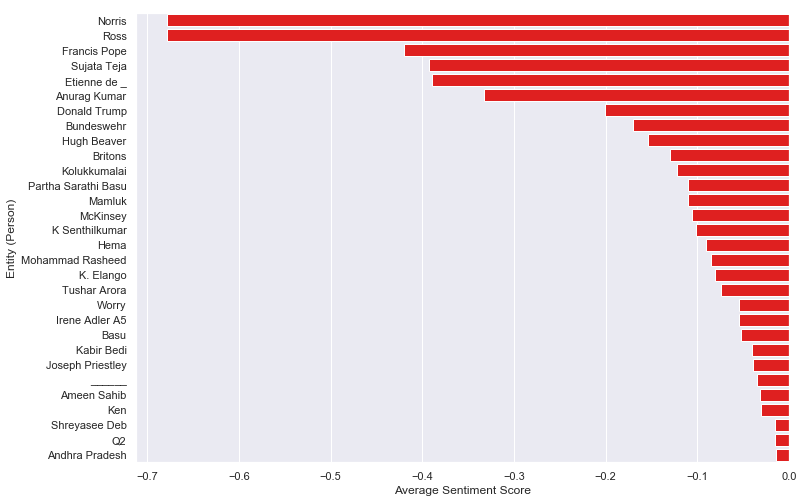

In [15]:
plotSentScores(sent_scores['PERSON'], -30, ['Entity (Person)', 'Average Sentiment Score'])

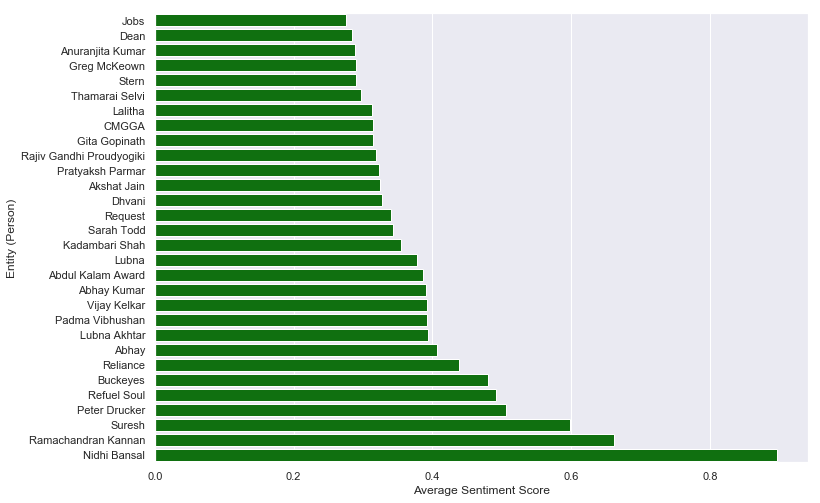

In [16]:
plotSentScores(sent_scores['PERSON'], 30, ['Entity (Person)', 'Average Sentiment Score'])

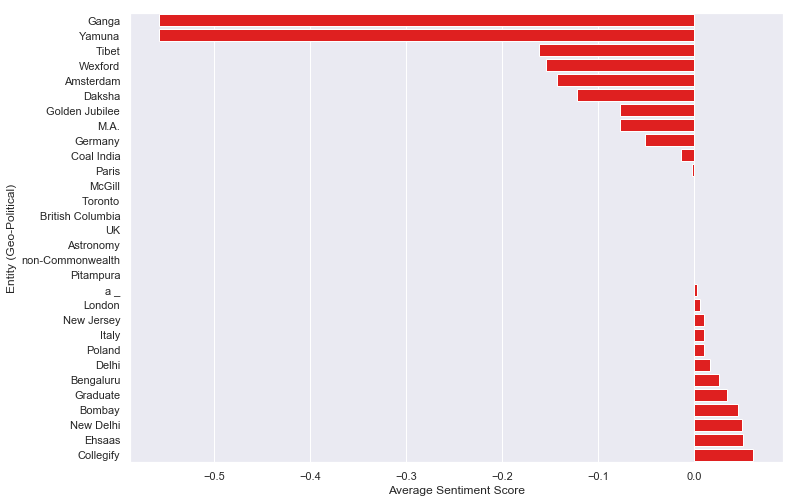

In [17]:
plotSentScores(sent_scores['GPE'], -30, ['Entity (Geo-Political)', 'Average Sentiment Score'])

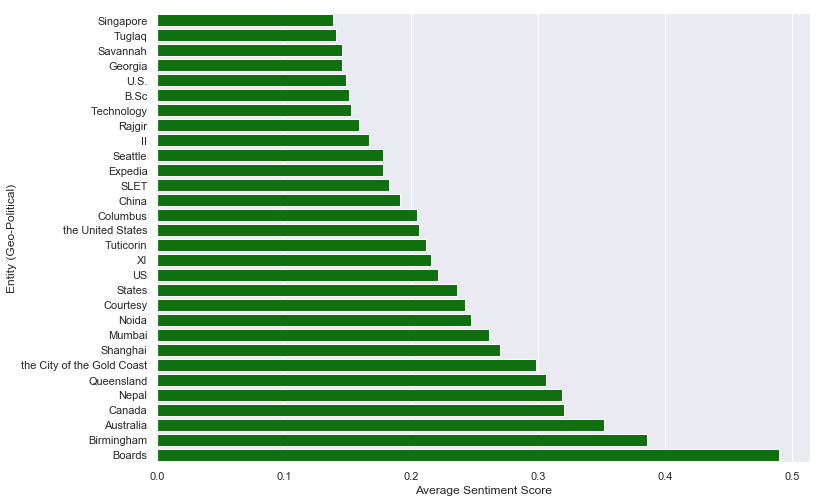

In [18]:
plotSentScores(sent_scores['GPE'], 30, ['Entity (Geo-Political)', 'Average Sentiment Score'])

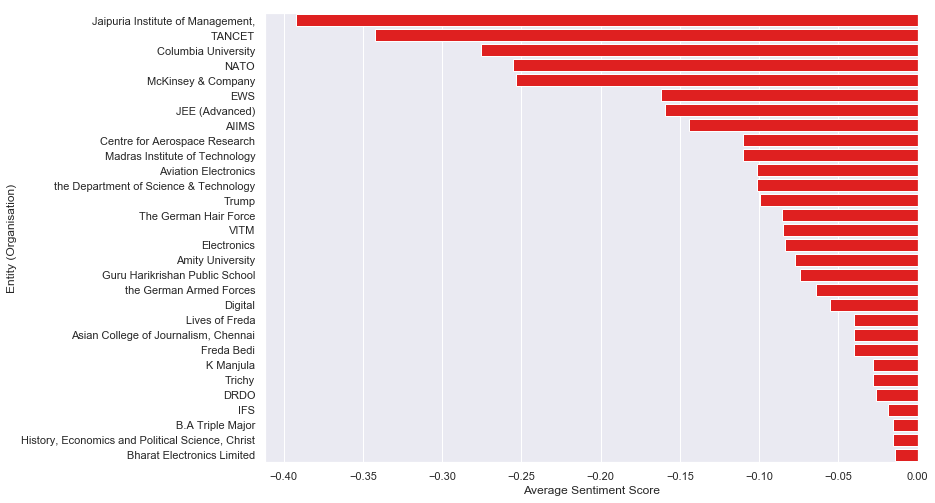

In [19]:
plotSentScores(sent_scores['ORG'], -30, ['Entity (Organisation)', 'Average Sentiment Score'])

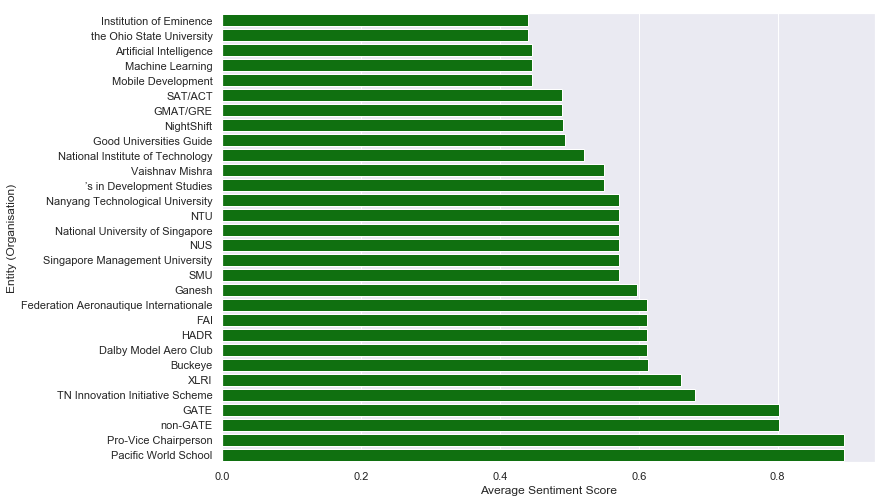

In [20]:
plotSentScores(sent_scores['ORG'], 30, ['Entity (Organisation)', 'Average Sentiment Score'])